### This notebook demonstrate the conversion of Keras model  to MDF


In [1]:
# importing MDF libraries

import numpy as np
from modeci_mdf.utils import simple_connect
from modeci_mdf.mdf import *
from modeci_mdf.execution_engine import EvaluableGraph
import graph_scheduler


In [2]:
# importing tensorflow library

from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow import keras



In [3]:
# fetching out the helper functions from the Keras_MDF script

from keras2mdf import *

In [4]:
# printing out the layers in the keras model

new_model = tf.keras.models.load_model("kr_N_model.h5")
for x in new_model.layers:
    print(x.name)



flatten
dense
dense_1
dense_2


In [5]:
# selective layers to extract
layers_to_extract = [ "dense", "dense_1", "dense_2"]

In [6]:
# getting the weights and activations of layer

params, activations = get_weights_and_activation(layers_to_extract, new_model)


In [7]:
# creating the model and graph from init_model_with_graph

mod, mod_graph = init_model_with_graph("keras_to_MDF", "Keras_to_MDF_graph")

In [8]:
#checking the input shape of the first dense layer of the keras model

new_model.layers[1].input_shape

(None, 784)

In [9]:
# loading the mnist dataset

mnist = tf.keras.datasets.mnist

In [10]:
# splitting the dataset into training and validation datasets

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# remove first image array from the test data and assign it to the validation data
x_val, x_test = x_test[1:, :, :], x_test[0, :, :]

# get the shape of the test data
x_test.shape

(28, 28)

In [11]:
# transforming the input image by rescaling the pixel values to 0-1

input = x_test/255

In [12]:
# reshape the input image to include the batch size

input = input.reshape(1,28,28)

In [13]:
# check the shape of the input
input.shape

(1, 28, 28)

In [14]:
# Make prediction with the input data

keras_prediction = new_model.predict(input, batch_size=1)

1/1 [==============================] - 2s 2s/step


In [15]:
# fetch the actual value

keras_pred = keras_prediction.argmax()

keras_pred


7

In [16]:
# reshape the input value
input_value = input.reshape(784,)


input_value.shape

(784,)

### Create Input Node for the model

In [17]:
# create input node for the mdf model

input_node = create_input_node("input_node", input_value)

# append the input node to the graph

mod_graph.nodes.append(input_node)



### Create First Dense Node of the model

In [18]:
# get weights and bias for the first dense node
weights = params["dense"]["weights"]
bias = params["dense"]["bias"]

# create first dense node of the model
dense_node = create_dense_node("dense_node", weights, bias)

#append the dense node to the graph
mod_graph.nodes.append(dense_node)


### Create First Activation Node for the model

In [19]:
#create activation on the first dense node
activation_node = create_activation_node("activation_node",  activations[0])

#append the activation node to the graph
mod_graph.nodes.append(activation_node)



### Create Second Dense Node

In [20]:
# get weights and bias for the first dense node
weights_1 = params["dense_1"]["weights"]
bias_1= params["dense_1"]["bias"]

#create second dense noe
dense1_node = create_dense_node("dense1_node", weights_1, bias_1)

#append second dense node to the graph
mod_graph.nodes.append(dense1_node)

### Create Second activation Node

In [21]:
#create activation on the second dense node
activation1_node = create_activation_node("activation1_node",  activations[1])

#append the second activation node to the graph
mod_graph.nodes.append(activation1_node)



### Create the third Dense Node

In [22]:
# get weights and bias for the first dense node
weights_2 = params["dense_2"]["weights"]
bias_2 = params["dense_2"]["bias"]

#create the third dense node
dense2_node = create_dense_node("dense2_node", weights_2, bias_2)

#append the third dense node to the graph
mod_graph.nodes.append(dense2_node)

### Create Third Activation Node

In [23]:
#create actiuvation on the third dense node
activation2_node = create_activation_node("activation2_node",  activations[2])

#append the activation to the node
mod_graph.nodes.append(activation2_node)


### Create connections between the Nodes 


In [24]:
e1 = simple_connect(input_node, dense_node, mod_graph)
e2 = simple_connect(dense_node, activation_node, mod_graph)
e3 = simple_connect(activation_node, dense1_node, mod_graph)
e4 = simple_connect(dense1_node, activation1_node, mod_graph)
e5 = simple_connect(activation1_node, dense2_node, mod_graph)
e6 = simple_connect(dense2_node, activation2_node, mod_graph)

### Generate Graph Image of the Model

Converting MDF graph: Keras_to_MDF_graph to graphviz (level: 1, format: png)
    Node: input_node
Bkgd color: None (#444444), font: black
    Node: dense_node
Bkgd color: None (#444444), font: black
    Node: activation_node
Bkgd color: None (#444444), font: black
    Node: dense1_node
Bkgd color: None (#444444), font: black
    Node: activation1_node
Bkgd color: None (#444444), font: black
    Node: dense2_node
Bkgd color: None (#444444), font: black
    Node: activation2_node
Bkgd color: None (#444444), font: black
    Edge: edge_input_node_dense_node connects input_node to dense_node
    Edge: edge_dense_node_activation_node connects dense_node to activation_node
    Edge: edge_activation_node_dense1_node connects activation_node to dense1_node
    Edge: edge_dense1_node_activation1_node connects dense1_node to activation1_node
    Edge: edge_activation1_node_dense2_node connects activation1_node to dense2_node
    Edge: edge_dense2_node_activation2_node connects dense2_node to acti

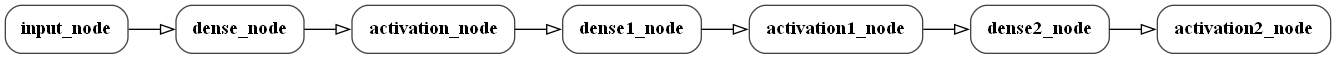

In [25]:
mod.to_graph_image(
        engine="dot",
        output_format="png",
        view_on_render=False,
        level=1,
        filename_root="keras_to_MDF",
        is_horizontal=True, 
        solid_color=True
)

from IPython.display import Image
Image(filename="Keras_to_MDF.png")


### Evaluating the model

In [26]:
eg = EvaluableGraph(mod_graph, verbose=False)

# evaluating the model 
eg.evaluate()


Init graph: Keras_to_MDF_graph
Evaluating graph: Keras_to_MDF_graph, root nodes: ['input_node'], with array format numpy


### MDF Output

In [27]:
# get mdf prediction

mdf_prediction = eg.enodes["activation2_node"].evaluable_outputs["activation2_node_out"].curr_value

mdf_prediction

array([1.68053503e-20, 1.31273300e-17, 2.32602213e-11, 1.11936086e-09,
       1.57835473e-22, 5.58742056e-16, 1.03078250e-29, 9.99999999e-01,
       7.86166791e-17, 3.54559236e-16])

In [28]:
# get max prediction probability

mdf_pred = mdf_prediction.argmax()

In [29]:
#confirm keras prediction is the same as MDF

assert keras_pred == mdf_pred
print("keras prediction is the same as mdf prediction")

keras prediction is the same as mdf prediction
